# Data generation

In [13]:
import navis
import pymaid
import flybrains

import navis.interfaces.neuprint as neu
import pandas as pd

# Connect to neuprint/CATMAID
rm = pymaid.connect_catmaid()
client = neu.Client('https://neuprint.janelia.org', dataset='hemibrain:v1.1')

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [14]:
navis.set_pbars(jupyter=False)
pymaid.set_pbars(jupyter=False)

In [4]:
# Pre-compiled labels for the ALPNs
labels = pd.read_csv('meta.csv', index_col=0)
labels.head()

,id,name,lineage,label,is_canonical,ntype,source
0,2863104,Uniglomerular mALT DA1 lPN 57316 2863105 ML,lPN,DA1_lPN,True,uPN,FAFB(R)
1,57349,Uniglomerular mALT DA3 adPN 57350 HG,adPN,DA3_adPN,True,uPN,FAFB(R)
2,12201990,neuron 12201991 mPN mALT left GD Amy,lPN,NaN,False,mPN,FAFB(L)
3,57353,Uniglomerular mALT DA1 lPN 57354 GA,lPN,DA1_lPN,True,uPN,FAFB(R)
4,12201994,neuron 12201995 mPN mALT left XZ former Dragon,lPN,NaN,False,mPN,FAFB(L)


In [5]:
# Quick sanity check
labels.groupby('source').size()

source
FAFB(L)    335
FAFB(R)    337
FIB        333
dtype: int64

In [ ]:
fafb_l = pymaid.get_neurons(labels[labels.source == 'FAFB(L)'].id.values, with_connectors=False)

In [ ]:
fafb_r = pymaid.get_neurons(labels[labels.source == 'FAFB(R)'].id.values, with_connectors=False)

In [ ]:
fib = neu.fetch_skeletons(labels[labels.source == 'FIB'].id.values, with_synapses=False)

In [15]:
# Xform all neurons into the same space
fib_jrc2018f = navis.xform_brain(fib, source='JRCFIB2018Fraw', target='JRC2018F')
fafb_l_jrc2018f = navis.xform_brain(fafb_l, source='FAFB14', target='JRC2018F')
fafb_r_jrc2018f = navis.xform_brain(fafb_r, source='FAFB14', target='JRC2018F')

Transform path: JRCFIB2018Fraw -> JRCFIB2018F -> JRCFIB2018Fum -> JRC2018F


INFO  : Pre-caching deformation field(s) for transforms... (navis)


Transform path: FAFB14 -> FAFB14um -> JRC2018F


INFO  : Pre-caching deformation field(s) for transforms... (navis)


Transform path: FAFB14 -> FAFB14um -> JRC2018F


INFO  : Pre-caching deformation field(s) for transforms... (navis)


In [17]:
# Mirror LHS FAFB PNs to the right
fafb_l_jrc2018f_mirror = navis.mirror_brain(fafb_l_jrc2018f, template='JRC2018F')

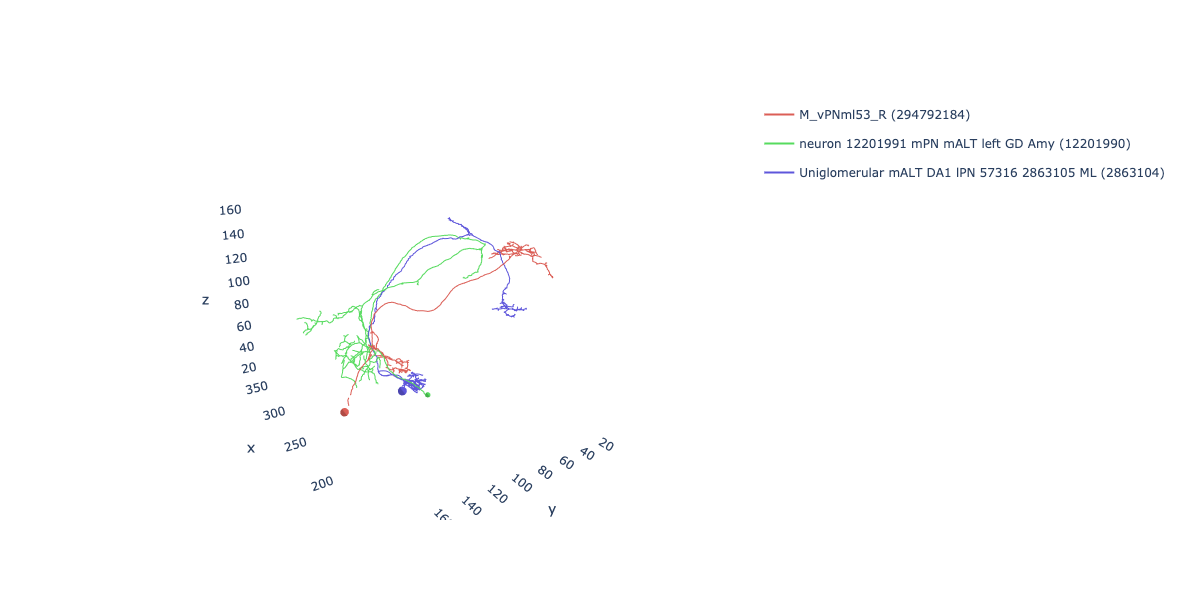

In [18]:
# Quick sanity check
navis.plot3d([fib_jrc2018f[0], fafb_l_jrc2018f_mirror[0], fafb_r_jrc2018f[0]])

In [19]:
# Prune terminal twigs smaller than 1 micron
fib_jrc2018f_twigs = fib_jrc2018f.apply(navis.prune_twigs, size=1, recursive=False, parallel=True, exact=False)
fafb_l_jrc2018f_mirror_twigs = fafb_l_jrc2018f_mirror.apply(navis.prune_twigs, size=1, recursive=False, parallel=True, exact=False)
fafb_r_jrc2018f_twigs = fafb_r_jrc2018f.apply(navis.prune_twigs, size=1, recursive=False, parallel=True, exact=False)

In [24]:
# Load a approximate bounding box for the hemibrain volume
import hemipy as hp
hemibrain_bbox = hp.load_hemibrain(which='bbox')
hemibrain_bbox_jrc2018f = navis.xform_brain(hemibrain_bbox, source='JRCFIB2018Fraw', target='JRC2018F')

Transform path: JRCFIB2018Fraw -> JRCFIB2018F -> JRCFIB2018Fum -> JRC2018F


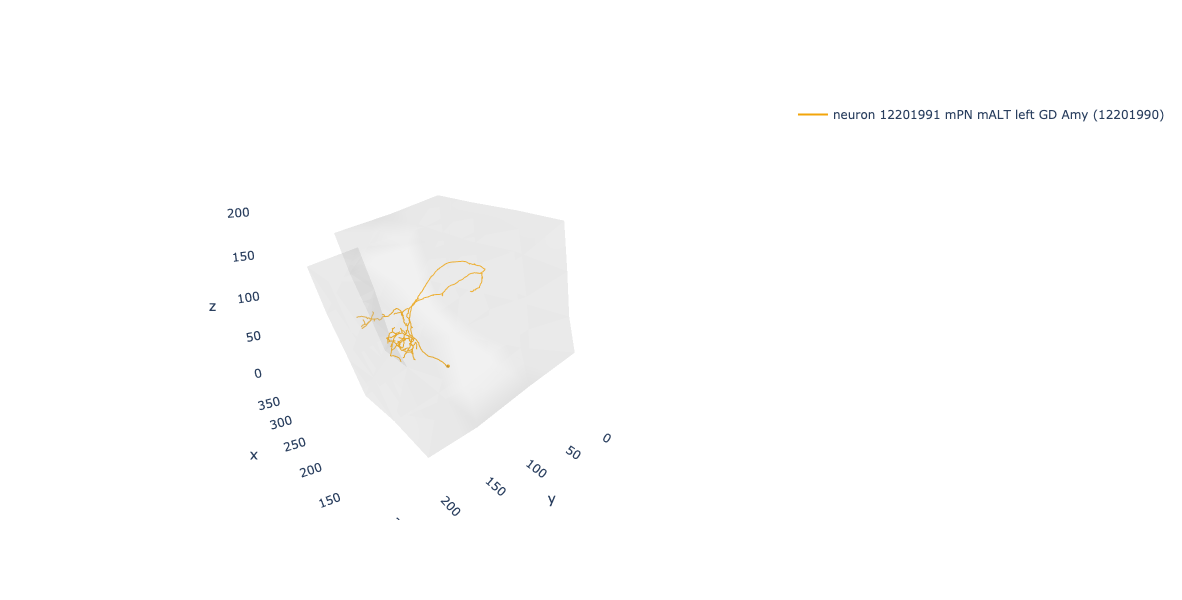

In [26]:
navis.plot3d([fafb_l_jrc2018f_mirror_twigs[0], hemibrain_bbox_jrc2018f])

In [33]:
# Resample to 1um and make dotprops
fafb_r_dps = navis.make_dotprops(fafb_r_jrc2018f_twigs, resample=1)
fafb_l_dps = navis.make_dotprops(fafb_l_jrc2018f_mirror_twigs, resample=1)
fib_dps = navis.make_dotprops(fib_jrc2018f_twigs, resample=1)

In [34]:
# Prune FAFB dotprops to hemibrain boundaries
fafb_r_dps_bbox = navis.in_volume(fafb_r_dps, hemibrain_bbox_jrc2018f)
fafb_l_dps_bbox = navis.in_volume(fafb_l_dps, hemibrain_bbox_jrc2018f)

OK - so the logic for the actual NBLASTs is as follows:
1. For FAFB L vs FAFB L we use the full neurons
2. For FAFB (L and R) vs FIB we use the pruned dotprops

In [47]:
# We need to make sure all IDs are the same data type
fafb_r_dps_bbox['id'] = fafb_r_dps_bbox.id.astype(int)
fafb_r_dps['id'] = fafb_r_dps.id.astype(int)
fafb_l_dps_bbox['id'] = fafb_l_dps_bbox.id.astype(int)
fafb_l_dps['id'] = fafb_l_dps.id.astype(int)

In [ ]:
# Bbox scores
scores = navis.nblast_allbyall((fib_dps + fafb_r_dps_bbox + fafb_l_dps_bbox))

In [ ]:
# Full scores
fscores = navis.nblast_allbyall(fafb_r_dps + fafb_l_dps)

In [53]:
# Combine 
comb_scores = scores.copy()
comb_scores.loc[fscores.index, fscores.columns] = fscores.values

comb_scores.to_csv('nblast_scores.csv')

comb_scores.head()

,294792184,509626405,541632990,542311358,480927537,481268653,542634818,417199910,329599710,542652506,...,561100,9752522,10991568,10991572,483289,2349018,2349022,4070,2349030,434153
294792184,1.000000,0.066647,0.345863,0.221968,0.374082,0.068712,-0.031436,0.005278,-0.106637,0.111179,...,-0.131890,-0.025644,-0.076771,-0.010813,-0.148870,-0.252824,-0.249435,-0.139435,-0.181114,-0.224113
509626405,0.186002,1.000000,-0.040097,-0.073380,-0.028248,-0.115401,0.026330,0.736912,0.258249,-0.098575,...,0.094897,-0.109566,-0.116462,0.323724,0.021287,0.027772,0.032437,0.040429,0.068423,0.075871
541632990,0.772674,-0.031476,1.000000,0.659888,0.853230,0.389022,0.041845,-0.113513,-0.230916,0.439862,...,-0.040296,0.211878,0.142681,0.033426,0.095460,-0.148261,-0.148394,-0.031491,0.022389,-0.098852
542311358,0.477152,-0.171664,0.503801,1.000000,0.479273,0.432665,0.017506,-0.259190,-0.293529,0.574516,...,-0.132040,0.219616,0.143318,0.136301,0.065601,-0.117533,-0.119610,0.038396,0.023134,-0.051855
480927537,0.798751,-0.034192,0.863079,0.643993,1.000000,0.420560,0.015841,-0.108327,-0.210823,0.451967,...,-0.027039,0.225294,0.146874,0.050180,0.040958,-0.137835,-0.137040,-0.059068,0.014852,-0.095744


In [57]:
comb_scores.T

,294792184,509626405,541632990,542311358,480927537,481268653,542634818,417199910,329599710,542652506,...,561100,9752522,10991568,10991572,483289,2349018,2349022,4070,2349030,434153
294792184,1.000000,0.186002,0.772674,0.477152,0.798751,0.476205,-0.086050,0.133574,-0.104558,0.366056,...,0.258380,0.199483,0.088458,-0.084740,0.082378,-0.140126,-0.137954,-0.133366,-0.047296,-0.190347
509626405,0.066647,1.000000,-0.031476,-0.171664,-0.034192,-0.198387,-0.177806,0.687171,0.041010,-0.150477,...,0.126607,-0.121620,-0.125379,-0.053720,-0.086736,-0.139041,-0.154638,-0.007314,-0.129395,-0.005327
541632990,0.345863,-0.040097,1.000000,0.503801,0.863079,0.468875,-0.157431,-0.101366,-0.315974,0.325499,...,0.225764,0.178083,0.051166,-0.132232,-0.019598,-0.215747,-0.213195,-0.193873,-0.105568,-0.241058
542311358,0.221968,-0.073380,0.659888,1.000000,0.643993,0.545640,-0.084130,-0.139255,-0.255115,0.516288,...,0.200936,0.226768,0.040388,-0.070709,0.024817,-0.215188,-0.225001,-0.025884,-0.075756,-0.136623
480927537,0.374082,-0.028248,0.853230,0.479273,1.000000,0.458095,-0.132777,-0.090811,-0.309994,0.311777,...,0.229295,0.170633,0.029626,-0.130582,-0.016067,-0.204752,-0.201112,-0.220833,-0.107529,-0.222229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349018,-0.252824,0.027772,-0.148261,-0.117533,-0.137835,-0.179439,-0.129898,0.001777,-0.254720,-0.097101,...,-0.201729,-0.036858,-0.018869,-0.042801,0.258064,1.000000,0.868024,0.071122,0.604091,0.176212
2349022,-0.249435,0.032437,-0.148394,-0.119610,-0.137040,-0.180934,-0.135964,0.010864,-0.249804,-0.100364,...,-0.201726,-0.028321,-0.021479,-0.038650,0.256570,0.883238,1.000000,0.066511,0.633906,0.167588
4070,-0.139435,0.040429,-0.031491,0.038396,-0.059068,-0.046200,-0.056385,-0.045806,-0.197695,0.056641,...,-0.207575,-0.099706,-0.222576,-0.023209,0.064356,0.021985,-0.043161,1.000000,0.013844,0.209874
2349030,-0.181114,0.068423,0.022389,0.023134,0.014852,0.010092,-0.090669,0.035039,-0.234988,-0.038112,...,-0.159604,-0.046737,-0.029438,-0.040131,0.372648,0.726659,0.744230,0.081302,1.000000,0.228479
